In [97]:
import polars as pl
from typing import List


def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量 = x_t - x_{t-lag}
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_momentum_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")

def reciprocal_sqrt_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col).sqrt() + 1e-8)).alias(f"{col}_rsqrt")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")

def reciprocal_sqrt_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col).sqrt() + 1e-8)).alias(f"{col}_rsqrt")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")


def sigmoid_expr(col: str) -> pl.Expr:
    return (1 / (1 + (-pl.col(col)).exp())).alias(f"{col}_sigmoid")

def tanh_expr(col: str) -> pl.Expr:
    return pl.col(col).tanh().alias(f"{col}_tanh")

def boxcox_expr(col: str, lam: float = 0.0) -> pl.Expr:
    # Box-Cox: 当 lam=0时，等同于 log(x + 1)
    # 这里为了安全，先加1避免0或负数
    if lam == 0:
        return (pl.col(col) + 1).log().alias(f"{col}_boxcox_{lam}")
    else:
        return (((pl.col(col) + 1) ** lam - 1) / lam).alias(f"{col}_boxcox_{lam}")

def frac_diff_expr(col: str, d: float = 0.5, threshold: float = 1e-5, max_len: int = 20) -> pl.Expr:
    weights = [1.0]
    for k in range(1, max_len):
        w = -weights[-1] * (d - k + 1) / k
        if abs(w) < threshold:
            break
        weights.append(w)
    weights.reverse()
    return (
        sum(pl.col(col).shift(i) * w for i, w in enumerate(weights))
        .alias(f"{col}_fracdiff_d{d:.2f}")
    )

def rolling_entropy_expr(col: str, window: int) -> pl.Expr:
    import polars.selectors as cs
    return (
        pl.col(col)
        .map_elements(lambda x: round(x, 2))  # 简化小数带来的唯一值过多问题
        .rolling_map(lambda values: -sum(
            (p := values.count(val) / len(values)) * (p if p == 0 else (p).log()) 
            for val in set(values)
        ), window_size=window)
        .alias(f"{col}_rolling_entropy_{window}")
    )

def conditioned_cross_expr(a: str, b: str) -> pl.Expr:
    mean_a = pl.col(a).mean()
    return (
        pl.when(pl.col(a) > mean_a)
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_mean")
    )

def fft_power_topk_expr(col: str, k: int = 3) -> pl.Expr:
    def topk_fft(x: list[float]) -> float:
        fft = np.fft.fft(x)
        powers = np.abs(fft[: len(fft)//2])  # 只取正频率
        return np.sum(np.sort(powers)[-k:])
    return (
        pl.col(col)
        .rolling_apply(topk_fft, window_size=64)
        .alias(f"{col}_fft_power_top{k}")
    )

def rolling_skew_shift_expr(col: str, window: int) -> pl.Expr:
    return (
        (pl.col(col).rolling_skew(window) - pl.col(col).rolling_skew(window).shift(1))
        .alias(f"{col}_skew_shift_{window}")
    )


def triple_cross_expr(cols: List[str]) -> List[pl.Expr]:
    exprs = []
    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                exprs.append(
                    (pl.col(cols[i]) * pl.col(cols[j]) * pl.col(cols[k]))
                    .alias(f"{cols[i]}_X_{cols[j]}_X_{cols[k]}")
                )
    return exprs

def triple_max_mid_min_expr(cols: List[str]) -> List[pl.Expr]:
    exprs = []
    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                max_col = pl.max_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                mean_col = pl.mean_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                min_col = pl.min_horizontal([pl.col(cols[i]), pl.col(cols[j]), pl.col(cols[k])])
                exprs.append(
                    ((max_col - mean_col) / (mean_col - min_col + 1e-8))
                    .alias(f"{cols[i]}_{cols[j]}_{cols[k]}_max_mean_min_ratio")
                )
    return exprs

def batch_apply_transforms(df: pl.DataFrame, window: int, lag: int, exclude_cols: List[str] = None) -> pl.DataFrame:
    if exclude_cols is None:
        exclude_cols = ['price', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    base_cols = [
        col for col in cols
        if col not in exclude_cols and not (
            col.endswith('_rolling_mean') or
            col.endswith('_rolling_std') or
            col.endswith('_scaled')
        )
    ]

    exprs = []

    # single features transformation
    for col in base_cols:
        exprs.extend([
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            sigmoid_expr(col),
            tanh_expr(col),
            boxcox_expr(col, lam=0),
            (pl.col(col) ** 2).alias(f"{col}_squared"),
            (pl.col(col).sqrt()).alias(f"{col}_sqrt"),
            (pl.col(col).log1p()).alias(f"{col}_log1p"),
        ])

    # double features transformation
    n = len(base_cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = base_cols[i], base_cols[j]
            exprs.extend([
                (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}"),
                (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}"),
                ((pl.col(a) / (pl.col(b) + 1e-8)).log()).alias(f"{a}_LOGR_{b}")
            ])

    # triple features transformation
    exprs.extend(triple_cross_expr(base_cols))
    exprs.extend(triple_max_mid_min_expr(base_cols))

    return df.with_columns(exprs)



In [2]:
df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors__threshold0.0005_rolling200.csv")

In [5]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # 新增 datetime 列，不覆盖原始时间戳
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # 按周截断，用新的 datetime 列
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    # 获取唯一周
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # 每周筛选子 DataFrame，保留所有列
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


In [7]:
# 假设你已有 df
weekly_dataframes = split_df_by_week(df)
print(f"共拆成 {len(weekly_dataframes)} 个周数据帧")


共拆成 7 个周数据帧


In [9]:
print(weekly_dataframes[0])

shape: (3_440, 49)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬──────────────────────┬─────────────────────┬─────────────────────┬──────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed_b ┆ oi_long_breakout_si ┆ oi_short_breakout_s ┆ timestamp_dt │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ y_orderflo…          ┆ gnal                ┆ ignal               ┆ ---          │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                  ┆ ---                 ┆ ---                 ┆ datetime[μs] │
│                  ┆         ┆              ┆               ┆   ┆ f64                  ┆ f64                 ┆ f64                 ┆              │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪══════════════════════╪═════════════════════╪═════════════════════╪══════════════╡
│ 1743919408338000 ┆ 83381.5 ┆ 487.007      ┆ 418.752       ┆ … ┆ 0.0                  ┆ 0.02

In [11]:
df = batch_apply_transforms(weekly_dataframes[1], 200, 1)

In [13]:
print(df)
print(df.estimated_size() / (1024 ** 2), "MB")

shape: (39_407, 34_112)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivit ┆ momentum_confirme │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ y_oi_long_bre…    ┆ d_by_orderflo…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743984014703000 ┆ 78350.5 ┆ 33.399       ┆ 83.261        ┆ … ┆ 0.498917           ┆ 0

In [17]:
print(df)

# 打印 Polars DataFrame 占用内存（MB）
print(f"Polars DataFrame size: {df.estimated_size() / (1024 ** 2):.4f} MB")

# 转成 Pandas DataFrame
pdf = df.to_pandas()

# 打印 Pandas DataFrame 的内存占用（MB）
print(f"Pandas DataFrame size: {pdf.memory_usage(deep=True).sum() / (1024 ** 2):.4f} MB")

shape: (39_407, 3_752)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed ┆ oi_long_breakout_s ┆ oi_long_breakout_ ┆ oi_long_breakout_ │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _by_orderflo…      ┆ ignal_X_oi_s…      ┆ signal_DIV_oi…    ┆ signal_LOGR_o…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743984014703000 ┆ 78350.5 ┆ 33.399       ┆ 83.261        ┆ … ┆ -inf               ┆ 0.

In [19]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 1000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")
# 👇 查看空值最多的列
max_null_col = null_counts.idxmax()
max_null_count = null_counts.max()
print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")

timestamp                                                           0
price                                                               0
sum_buy_size                                                        0
sum_sell_size                                                       0
timestamp_duration                                                  0
                                                                 ... 
momentum_confirmed_by_orderflow_DIV_oi_short_breakout_signal        0
momentum_confirmed_by_orderflow_LOGR_oi_short_breakout_signal    8313
oi_long_breakout_signal_X_oi_short_breakout_signal                  0
oi_long_breakout_signal_DIV_oi_short_breakout_signal                0
oi_long_breakout_signal_LOGR_oi_short_breakout_signal               0
Length: 3752, dtype: int64
sum_buy_size_skew                                                  398
sum_buy_size_kurt                                                  398
sum_buy_size_diff_1                                          

In [21]:
pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

shape: (38_571, 3_112)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed ┆ oi_long_breakout_s ┆ oi_long_breakout_ ┆ oi_long_breakout_ │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _by_orderflo…      ┆ ignal_X_oi_s…      ┆ signal_DIV_oi…    ┆ signal_LOGR_o…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64               ┆ f64               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 2.8712e7           ┆ 0.

In [17]:
import numpy as np
from tqdm import tqdm

def avg_steps_to_volatility_median(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.median(steps_list))

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

prices_np = df["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的均值步数:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的均值步数:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的均值步数:", avg_steps_2pct)

avg_steps_05pct_median = avg_steps_to_volatility_median(prices_np, 0.005)  # 波动1%
print("波动 ±0.5% 的中位步数:", avg_steps_05pct_median)
avg_steps_1pct_median = avg_steps_to_volatility_median(prices_np, 0.01)  # 波动1%
print("波动 ±1% 的中位步数:", avg_steps_1pct_median)
avg_steps_2pct_median = avg_steps_to_volatility_median(prices_np, 0.02)  # 波动1%
print("波动 ±2% 的中位步数:", avg_steps_2pct_median)

cal abs change 0.50% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:00<00:00, 49979.51it/s]


波动 ±0.5% 的均值步数: 109


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:02<00:00, 14672.86it/s]


波动 ±1% 的均值步数: 377


cal abs change 2.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 39407/39407 [00:09<00:00, 4234.64it/s]


波动 ±2% 的均值步数: 1312


cal abs change 0.50% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:00<00:00, 50330.03it/s]


波动 ±0.5% 的中位步数: 77


cal abs change 1.00% avg steps: 100%|████████████████████████████████████████████████████████████████████| 39407/39407 [00:02<00:00, 14703.10it/s]


波动 ±1% 的中位步数: 306


cal abs change 2.00% avg steps: 100%|█████████████████████████████████████████████████████████████████████| 39407/39407 [00:09<00:00, 4311.28it/s]

波动 ±2% 的中位步数: 1119


In [19]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

In [21]:
df = df.with_columns([
    future_return_expr("price", avg_steps_05pct),
    future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [25]:
import pandas as pd

# 假设 pdf 是你的 pandas DataFrame
pdf = df.to_pandas()

# 查看每列空值数量
null_counts = pdf.isnull().sum()
print(null_counts)

# 或者只显示有空值的列
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 10000].index

# 删除这些列
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"删除了这些列：{list(cols_to_drop)}")
print(f"清理后DataFrame形状：{pdf_cleaned.shape}")

pdf_clean = pdf_cleaned.dropna()

# 转成 Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

timestamp                                                                                              0
price                                                                                                  0
sum_buy_size                                                                                           0
sum_sell_size                                                                                          0
timestamp_duration                                                                                     0
                                                                                                      ..
impact_sensitivity_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio                 0
momentum_confirmed_by_orderflow_oi_long_breakout_signal_oi_short_breakout_signal_max_mean_min_ratio    0
future_return_109                                                                                      0
future_return_377                                      

In [27]:
def future_timestamp_sum_duration_expr(ts_col: str, step: int) -> pl.Expr:
    return (
        pl.col(ts_col)
        .diff()
        .shift(-step + 1)
        .rolling_sum(window_size=step)
        .alias(f"future_duration_sum_{step}")
    )
    
df_ts = df.with_columns([
    future_timestamp_sum_duration_expr("timestamp", avg_steps_05pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_1pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_2pct),
])

df_ts = df_ts.slice(1)  # 跟 df 一致
df_ts = df_ts.select([
    f"future_duration_sum_{int(avg_steps_05pct)}",
    f"future_duration_sum_{int(avg_steps_1pct)}",
    f"future_duration_sum_{int(avg_steps_2pct)}",
    "timestamp_duration",
]).drop_nulls()

In [28]:
df_ts.describe()

shape: (9, 5)
┌────────────┬─────────────────────────┬─────────────────────────┬──────────────────────────┬────────────────────┐
│ statistic  ┆ future_duration_sum_109 ┆ future_duration_sum_377 ┆ future_duration_sum_1312 ┆ timestamp_duration │
│ ---        ┆ ---                     ┆ ---                     ┆ ---                      ┆ ---                │
│ str        ┆ f64                     ┆ f64                     ┆ f64                      ┆ f64                │
╞════════════╪═════════════════════════╪═════════════════════════╪══════════════════════════╪════════════════════╡
│ count      ┆ 34637.0                 ┆ 34637.0                 ┆ 34637.0                  ┆ 34637.0            │
│ null_count ┆ 0.0                     ┆ 0.0                     ┆ 0.0                      ┆ 0.0                │
│ mean       ┆ 1.4531e9                ┆ 5.0784e9                ┆ 1.8669e10                ┆ 1.2771e7           │
│ std        ┆ 2.0642e9                ┆ 6.3176e9                ┆ 1.7531e10                ┆ 2.9549e7           │
│ min        ┆ 3000.0                  ┆ 748000.0                ┆ 1.43084e8                ┆ 0.0                │
│ 25%        ┆ 1.30365e8               ┆ 8.8512e8                ┆ 4.8856e9                 ┆ 270000.0           │
│ 50%        ┆ 7.70401e8               ┆ 3.2608e9                ┆ 1.4156e10                ┆ 3.143e6            │
│ 75%        ┆ 1.7574e9                ┆ 6.0386e9                ┆ 2.5933e10                ┆ 1.2104e7           │
│ max        ┆ 1.5274e10               ┆ 3.9200e10               ┆ 7.7446e10                ┆ 8.5147e8           │
└────────────┴─────────────────────────┴─────────────────────────┴──────────────────────────┴────────────────────┘

In [29]:
2.0138e10		 / 1000000 / 3600

5.5938888888888885

In [27]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str = "future_return_200") -> dict:
    exclude_prefixes = ['price', 'timestamp', 'timestamp_dt', 'symbol']
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict

In [29]:
print(df.shape)
print(df.head())

(7407, 33547)
shape: (5, 33_547)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬───────────────────┬───────────────────┬────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed ┆ future_return_109 ┆ future_return_377 ┆ future_return_1312 │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ _by_orderflo…      ┆ ---               ┆ ---               ┆ ---                │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ f64               ┆ f64               ┆ f64                │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆                   ┆                   ┆                    │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪═══════════════════╪═══════════════════╪════════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 1.54161      

In [31]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_05pct}")

Calculating IC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 33541/33541 [05:44<00:00, 97.42it/s]


In [32]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


Top 20 features by IC:
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.119928
alt_factor_long_term_oi_trend_LOGR_far_ask_price: 0.119928
far_ask_price_DIV_factor_px_oi_divergence: 0.119876
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.119720
alt_factor_long_term_oi_trend_LOGR_best_ask_price: 0.119720
best_ask_price_DIV_factor_px_oi_divergence: 0.119637
alt_factor_long_term_oi_trend_DIV_mid_price: 0.119591
alt_factor_long_term_oi_trend_LOGR_mid_price: 0.119591
mid_price_DIV_factor_px_oi_divergence: 0.119422
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.119392
alt_factor_long_term_oi_trend_LOGR_best_bid_price: 0.119392
best_bid_price_DIV_factor_px_oi_divergence: 0.119301
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.119111
alt_factor_long_term_oi_trend_LOGR_far_bid_price: 0.119111
far_bid_price_DIV_factor_px_oi_divergence: 0.119007
alt_factor_short_term_oi_trend_DIV_best_ask_price: 0.093865
alt_factor_short_term_oi_trend_LOGR_best_ask_price: 0.093865
alt_factor_short_

In [33]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_1pct}")

Calculating IC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 33541/33541 [05:45<00:00, 97.18it/s]


In [34]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


Top 20 features by IC:
far_ask_price_DIV_factor_px_oi_divergence: 0.181901
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.181802
alt_factor_long_term_oi_trend_LOGR_far_ask_price: 0.181802
mid_price_DIV_factor_px_oi_divergence: 0.181640
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.181573
alt_factor_long_term_oi_trend_LOGR_best_ask_price: 0.181573
alt_factor_long_term_oi_trend_DIV_mid_price: 0.181486
alt_factor_long_term_oi_trend_LOGR_mid_price: 0.181486
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.181339
alt_factor_long_term_oi_trend_LOGR_best_bid_price: 0.181339
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.180731
alt_factor_long_term_oi_trend_LOGR_far_bid_price: 0.180731
alt_factor_short_term_oi_trend_DIV_best_bid_price: 0.145308
alt_factor_short_term_oi_trend_LOGR_best_bid_price: 0.145308
alt_factor_short_term_oi_trend_DIV_mid_price: 0.145194
alt_factor_short_term_oi_trend_LOGR_mid_price: 0.145194
alt_factor_short_term_oi_trend_DIV_best_ask_price: 0.145179
alt_

In [35]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_2pct}")

Calculating IC: 100%|███████████████████████████████████████████████████████████████████████████████████████| 33541/33541 [05:51<00:00, 95.55it/s]


In [36]:
# 按 IC 值排序（降序）
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


Top 20 features by IC:
alt_factor_long_term_oi_trend_DIV_far_ask_price: 0.341456
alt_factor_long_term_oi_trend_LOGR_far_ask_price: 0.341456
far_ask_price_DIV_factor_px_oi_divergence: 0.341363
alt_factor_long_term_oi_trend_DIV_best_ask_price: 0.340763
alt_factor_long_term_oi_trend_LOGR_best_ask_price: 0.340763
best_ask_price_DIV_factor_px_oi_divergence: 0.340680
alt_factor_long_term_oi_trend_DIV_mid_price: 0.340516
alt_factor_long_term_oi_trend_LOGR_mid_price: 0.340516
alt_factor_long_term_oi_trend_DIV_best_bid_price: 0.340256
alt_factor_long_term_oi_trend_LOGR_best_bid_price: 0.340256
best_bid_price_DIV_factor_px_oi_divergence: 0.340170
alt_factor_long_term_oi_trend_DIV_far_bid_price: 0.339576
alt_factor_long_term_oi_trend_LOGR_far_bid_price: 0.339576
far_bid_price_DIV_factor_px_oi_divergence: 0.339490
alt_factor_short_term_oi_trend_DIV_far_ask_price: 0.318771
alt_factor_short_term_oi_trend_LOGR_far_ask_price: 0.318771
alt_factor_short_term_oi_trend_DIV_best_ask_price: 0.318556
alt_fac

In [38]:
pdf_clean = df.to_pandas()


In [39]:
from scipy.stats import spearmanr
# 替换为你的目标收益列名
target_col = f"future_return_{avg_steps_2pct}"
factor_col = "spread_skew"

# 取出非空值（NaN 会自动剔除）
series1 = pdf_clean[factor_col]
series2 = pdf_clean[target_col]
print(series1.isna().sum(), series2.isna().sum())

# 计算 Spearman 相关系数
ic, pval = spearmanr(series1, series2)

print(f"Spearman IC: {ic:.6f}, p-value: {pval:.6g}")


0 0
Spearman IC: 0.088433, p-value: 1.41512e-65


In [37]:
def calc_hourly_rankic(
    df: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]

    # 微秒时间戳转换成datetime
    df = df.with_columns(
        pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us"))
    )

    # 截断到小时
    df = df.with_columns(
        pl.col(timestamp_col).dt.truncate("1h").alias("hour_group")
    )

    group = df.group_by("hour_group")

    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"), method="spearman").alias(factor)
        )

    ic_df = group.agg(agg_exprs)

    return ic_df


In [38]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    data = []
    for factor in tqdm(factor_cols, desc="Calculating IC stats"):
        mean_ic = ic_df.select(pl.col(factor).mean()).item()
        std_ic = ic_df.select(pl.col(factor).std()).item()
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": factor, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})
    
    return pl.DataFrame(data)


In [42]:
# 你的 pl.DataFrame 设为 df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # 每小时每因子的 IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


result = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(result)


shape: (156, 3_111)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ momentum_confirmed ┆ oi_long_breakout_s ┆ oi_long_breakout_s ┆ oi_long_breakout_s │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _by_orderflo…      ┆ ignal_X_oi_s…      ┆ ignal_DIV_oi…      ┆ ignal_LOGR_o…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-07   ┆ -0.623659 ┆ -0.139775    ┆ 0.056299      ┆ … ┆ -0.293301          ┆ NaN    

Calculating IC stats: 100%|█████████████████████████████████████████████████████████████████████████████████| 2983/2983 [00:01<00:00, 1773.92it/s]

shape: (2_983, 4)
┌─────────────────────────────────┬───────────┬──────────┬───────────┐
│ factor                          ┆ mean_ic   ┆ std_ic   ┆ ir        │
│ ---                             ┆ ---       ┆ ---      ┆ ---       │
│ str                             ┆ f64       ┆ f64      ┆ f64       │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╡
│ sum_buy_size                    ┆ -0.049473 ┆ 0.191089 ┆ -0.2589   │
│ sum_sell_size                   ┆ 0.059827  ┆ 0.177968 ┆ 0.336167  │
│ price_pct_change                ┆ -0.089918 ┆ 0.107867 ┆ -0.833596 │
│ buy_sell_imbalance              ┆ -0.129057 ┆ 0.174647 ┆ -0.738961 │
│ trades_side                     ┆ -0.100088 ┆ 0.140043 ┆ -0.714693 │
│ …                               ┆ …         ┆ …        ┆ …         │
│ momentum_confirmed_by_orderflo… ┆ NaN       ┆ NaN      ┆ NaN       │
│ momentum_confirmed_by_orderflo… ┆ -0.088867 ┆ 0.169466 ┆ -0.524394 │
│ oi_long_breakout_signal_X_oi_s… ┆ NaN       ┆ NaN      ┆ 

In [43]:
df

shape: (37_259, 3_115)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬───────────────────┬───────────────────┬────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ oi_long_breakout_s ┆ future_return_109 ┆ future_return_377 ┆ future_return_1312 │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ignal_LOGR_o…      ┆ ---               ┆ ---               ┆ ---                │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ f64               ┆ f64               ┆ f64                │
│                  ┆         ┆              ┆               ┆   ┆ f64                ┆                   ┆                   ┆                    │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪═══════════════════╪═══════════════════╪════════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 15.46              ┆ 0.00442           ┆ -0.006157         ┆ -0.027302          │
│ 1743988109683000 ┆ 78596.7 ┆ 12.658       ┆ 11.859        ┆ … ┆ 14.716603          ┆ 0.005429          ┆ -0.005157         ┆ -0.027848          │
│ 1743988117612000 ┆ 78557.2 ┆ 9.64         ┆ 19.887        ┆ … ┆ 8.200934           ┆ 0.006441          ┆ -0.004159         ┆ -0.026322          │
│ 1743988127362000 ┆ 78517.7 ┆ 7.196        ┆ 18.613        ┆ … ┆ -inf               ┆ 0.007452          ┆ -0.003155         ┆ -0.02687           │
│ 1743988142162000 ┆ 78557.5 ┆ 27.117       ┆ 11.867        ┆ … ┆ -inf               ┆ 0.006437          ┆ -0.004159         ┆ -0.026326          │
│ …                ┆ …       ┆ …            ┆ …             ┆ … ┆ …                  ┆ …                 ┆ …                 ┆ …                  │
│ 1744545613064000 ┆ 84507.8 ┆ 103.613      ┆ 23.69         ┆ … ┆ -inf               ┆ -0.008977         ┆ 0.005385          ┆ -0.008822          │
│ 1744545658368000 ┆ 84465.2 ┆ 64.626       ┆ 64.727        ┆ … ┆ -inf               ┆ -0.007975         ┆ 0.005156          ┆ -0.008821          │
│ 1744545686984000 ┆ 84507.5 ┆ 41.164       ┆ 20.673        ┆ … ┆ -inf               ┆ -0.008477         ┆ 0.005389          ┆ -0.008818          │
│ 1744545713349000 ┆ 84549.9 ┆ 89.57        ┆ 15.729        ┆ … ┆ -inf               ┆ -0.008478         ┆ 0.004149          ┆ -0.009816          │
│ 1744545769820000 ┆ 84507.6 ┆ 104.5        ┆ 104.587       ┆ … ┆ -inf               ┆ -0.007982         ┆ 0.005388          ┆ -0.009819          │
└──────────────────┴─────────┴──────────────┴───────────────┴───┴────────────────────┴───────────────────┴───────────────────┴────────────────────┘

In [44]:
def print_top_bottom_ic_ir_with_values(df: pl.DataFrame, top_n: int = 20, ic_abs_threshold=0.1):
    # drop NaNs
    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])
    pdf = pdf[ pdf["mean_ic"].abs() > ic_abs_threshold ]

    df_filtered = pl.from_pandas(pdf)

    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}}  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    ic_top_rows = df_filtered.sort("mean_ic", descending=True).head(top_n).to_dicts()
    ic_bottom_rows = df_filtered.sort("mean_ic").head(top_n).to_dicts()
    ir_top_rows = df_filtered.sort("ir", descending=True).head(top_n).to_dicts()
    ir_bottom_rows =df_filtered.sort("ir").head(top_n).to_dicts()

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("📉 Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

    factor_list = pdf['factor'].tolist()
    return factor_list

factors_selected = print_top_bottom_ic_ir_with_values(result, top_n=20, ic_abs_threshold=0.1)
# print(factors_selected)


📈 Top IC Factors:
 1. alt_factor_long_term_oi_trend_DIV_best_ask_price   mean_ic: 0.574623
 2. alt_factor_long_term_oi_trend_LOGR_best_ask_price  mean_ic: 0.574623
 3. far_ask_price_DIV_factor_px_oi_divergence          mean_ic: 0.574317
 4. alt_factor_long_term_oi_trend_DIV_far_ask_price    mean_ic: 0.574231
 5. alt_factor_long_term_oi_trend_LOGR_far_ask_price   mean_ic: 0.574231
 6. alt_factor_long_term_oi_trend_DIV_mid_price        mean_ic: 0.574119
 7. alt_factor_long_term_oi_trend_LOGR_mid_price       mean_ic: 0.574119
 8. mid_price_DIV_factor_px_oi_divergence              mean_ic: 0.573873
 9. best_ask_price_DIV_factor_px_oi_divergence         mean_ic: 0.573582
10. far_bid_price_DIV_factor_px_oi_divergence          mean_ic: 0.573473
11. alt_factor_long_term_oi_trend_DIV_far_bid_price    mean_ic: 0.573177
12. alt_factor_long_term_oi_trend_LOGR_far_bid_price   mean_ic: 0.573177
13. alt_factor_long_term_oi_trend_DIV_best_bid_price   mean_ic: 0.572998
14. alt_factor_long_term_oi_trend

In [48]:
import polars as pl
import pandas as pd
import re

def get_factor_core_name(factor_name):
    core = re.split(r'(_DIV_|_LOGR_|_X_)', factor_name)[0]
    return core

def deduplicate_with_core(df: pl.DataFrame, metric='mean_ic'):
    pdf = df.to_pandas()
    pdf['core_factor'] = pdf['factor'].apply(get_factor_core_name)
    # 先排序保证取最大metric时是对应的行
    pdf = pdf.sort_values(metric, ascending=False)
    # 取每个core_factor表现最好的那条
    pdf = pdf.drop_duplicates(subset=['core_factor'])
    return pl.from_pandas(pdf)

def print_top_bottom_ic_ir_with_core(df: pl.DataFrame, top_n: int = 20):
    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} ({row['core_factor']})  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])

    ic_top_rows = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient='records')
    ic_bottom_rows = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient='records')
    ir_top_rows = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient='records')
    ir_bottom_rows = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient='records')

    print("📈 Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("📉 Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("📈 Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("📉 Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

# 去重示例
df_dedup = deduplicate_with_core(result, metric='mean_ic')
print_top_bottom_ic_ir_with_core(df_dedup, top_n=20)


📈 Top IC Factors:
 1. alt_factor_long_term_oi_trend_DIV_best_ask_price                         (alt_factor_long_term_oi_trend)  mean_ic: 0.574623
 2. far_ask_price_DIV_factor_px_oi_divergence                                (far_ask_price)  mean_ic: 0.574317
 3. mid_price_DIV_factor_px_oi_divergence                                    (mid_price)  mean_ic: 0.573873
 4. best_ask_price_DIV_factor_px_oi_divergence                               (best_ask_price)  mean_ic: 0.573582
 5. far_bid_price_DIV_factor_px_oi_divergence                                (far_bid_price)  mean_ic: 0.573473
 6. best_bid_price_DIV_factor_px_oi_divergence                               (best_bid_price)  mean_ic: 0.572858
 7. alt_factor_short_term_oi_trend_DIV_best_ask_price                        (alt_factor_short_term_oi_trend)  mean_ic: 0.504610
 8. spread_LOGR_far_bid_price                                                (spread)  mean_ic: 0.390192
 9. alt_open_interest_data_sumOpenInterestValue_DIV_factor_px_

In [48]:
# 你的 pl.DataFrame 设为 df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # 每小时每因子的 IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


shape: (156, 33_543)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivity ┆ momentum_confirmed │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ _oi_long_bre…      ┆ _by_orderflo…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-08   ┆ -0.711042 ┆ -0.506708    ┆ 0.325077      ┆ … ┆ 0.085655           ┆ -0.585

In [50]:
ic_hourly = ic_hourly.sort("hour_group")
print(ic_hourly)

shape: (156, 33_543)
┌──────────────┬───────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ hour_group   ┆ price     ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ impact_sensitivity ┆ impact_sensitivity ┆ impact_sensitivity ┆ momentum_confirmed │
│ ---          ┆ ---       ┆ ---          ┆ ---           ┆   ┆ _momentum_co…      ┆ _momentum_co…      ┆ _oi_long_bre…      ┆ _by_orderflo…      │
│ datetime[μs] ┆ f64       ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---                ┆ ---                │
│              ┆           ┆              ┆               ┆   ┆ f64                ┆ f64                ┆ f64                ┆ f64                │
╞══════════════╪═══════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2025-04-07   ┆ -0.973756 ┆ -0.431676    ┆ -0.115969     ┆ … ┆ -0.143911          ┆ -0.267

In [52]:
def classify_ic_ir_cols(cols):
    """
    分类以 `_ic` 和 `_ir` 结尾的列，返回两个字典：
    ic_cols: {factor_name: full_col_name}
    ir_cols: {factor_name: full_col_name}
    """
    ic_cols = {}
    ir_cols = {}

    for col in cols:
        if col.endswith("_ic"):
            factor = col[:-3]
            ic_cols[factor] = col
        elif col.endswith("_ir"):
            factor = col[:-3]
            ir_cols[factor] = col

    return ic_cols, ir_cols

def extract_ic_ir_data(df: pl.DataFrame):
    ic_cols, ir_cols = classify_ic_ir_cols(df.columns)

    # 只提取每列的第一个元素（通常只有一行）
    ic_data = {factor: df[col][0] for factor, col in ic_cols.items()}
    ir_data = {factor: df[col][0] for factor, col in ir_cols.items()}

    return ic_cols, ir_cols, ic_data, ir_data

def print_top_bottom_ic(ic_results: dict, top_n=20):
    # 按 IC 降序排序
    sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} features by IC:")
    for feat, ic in sorted_ic[:top_n]:
        print(f"{feat}: {ic:.6f}")

    print(f"\nBottom {top_n} features by IC:")
    for feat, ic in sorted_ic[-top_n:]:
        print(f"{feat}: {ic:.6f}")

def print_top_bottom_ir(ir_results: dict, top_n=20):
    sorted_ir = sorted(ir_results.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop {top_n} features by IR:")
    for feat, ir in sorted_ir[:top_n]:
        print(f"{feat}: {ir:.6f}")

    print(f"\nBottom {top_n} features by IR:")
    for feat, ir in sorted_ir[-top_n:]:
        print(f"{feat}: {ir:.6f}")


In [54]:
print(ic_hourly.select("far_bid_price_DIV_factor_px_oi_divergence"))


shape: (156, 1)
┌─────────────────────────────────┐
│ far_bid_price_DIV_factor_px_oi… │
│ ---                             │
│ f64                             │
╞═════════════════════════════════╡
│ 0.972926                        │
│ 0.926316                        │
│ 0.318087                        │
│ 0.687421                        │
│ 0.497126                        │
│ …                               │
│ 0.828571                        │
│ 0.898363                        │
│ 0.95                            │
│ 0.542857                        │
│ 0.892857                        │
└─────────────────────────────────┘


In [56]:
target_col = f"future_return_{avg_steps_2pct}"
x_col = 'alt_factor_long_term_oi_trend_DIV_best_ask_price'

df_cleaned_for_icir = df.drop_nulls(subset=[x_col, target_col, 'timestamp'])

icir_df = df_cleaned_for_icir.select([x_col, target_col, 'timestamp']).to_pandas()
print(icir_df)

      alt_factor_long_term_oi_trend_DIV_best_ask_price  future_return_1312  \
0                                             0.928066           -0.027302   
1                                             0.928498           -0.027846   
2                                             0.929425           -0.026867   
3                                             0.929830           -0.025342   
4                                             0.928065           -0.027295   
...                                                ...                 ...   
7402                                          0.951079           -0.014267   
7403                                          0.953456           -0.008300   
7404                                          0.953926           -0.008298   
7405                                          0.953810           -0.007304   
7406                                          0.954405           -0.007307   

             timestamp  
0     1743988103953000  
1     1743988

In [58]:
import pandas as pd

icir_df['timestamp'] = pd.to_datetime(icir_df['timestamp'], unit='us')
icir_df = icir_df.sort_values('timestamp').set_index('timestamp').dropna()


                         alt_factor_long_term_oi_trend_DIV_best_ask_price  \
timestamp                                                                   
2025-04-07 01:08:23.953                                          0.928066   
2025-04-07 01:08:29.683                                          0.928498   
2025-04-07 01:09:55.825                                          0.929425   
2025-04-07 01:09:59.435                                          0.929830   
2025-04-07 01:10:56.301                                          0.928065   
...                                                                   ...   
2025-04-13 12:15:22.083                                          0.951079   
2025-04-13 12:23:56.076                                          0.953456   
2025-04-13 12:24:52.397                                          0.953926   
2025-04-13 12:25:55.340                                          0.953810   
2025-04-13 12:26:43.890                                          0.954405   

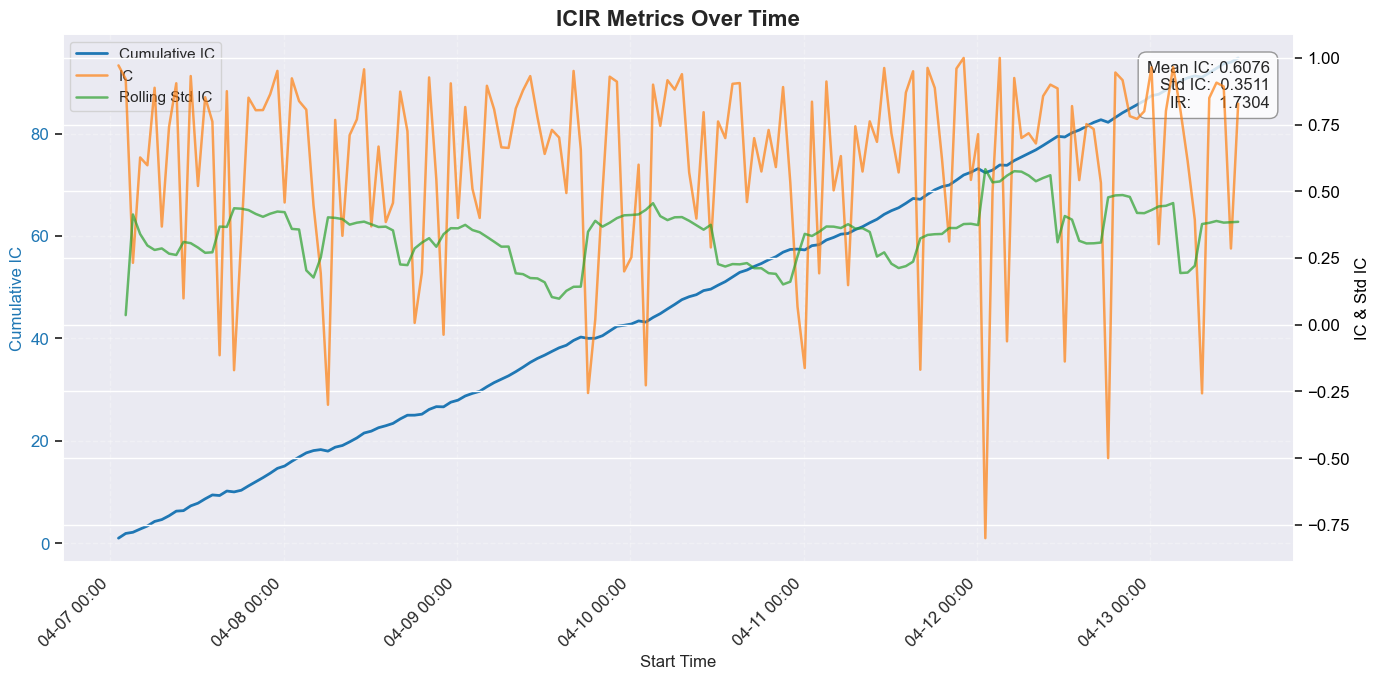

In [60]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns

def calc_ic(df, x_col, target_col):
    # 用斯皮尔曼相关计算IC
    if len(df) < 2:
        return np.nan
    corr, _ = spearmanr(df[x_col], df[target_col], nan_policy='omit')
    return corr

print(icir_df)


hourly_starts = pd.date_range(start=icir_df.index.min(), end=icir_df.index.max(), freq='1h')

ic_list = []

for start_time in hourly_starts:
    end_time = start_time + pd.Timedelta('1h')
    window_df = icir_df[start_time:end_time]
    ic = calc_ic(window_df, x_col, target_col)
    ic_list.append({'start_time': start_time, 'ic': ic})

ic_df = pd.DataFrame(ic_list).dropna()
print(ic_df)
print(ic_hourly.select(x_col))
print("Pandas IC DataFrame 列均值：")
print(ic_df.mean(numeric_only=True))
mean_val = ic_hourly.select(
    pl.col(x_col).mean()
)
print("Polars 中指定列的均值：")
print(mean_val)

mean_ic = ic_df['ic'].mean()
std_ic = ic_df['ic'].std()
ir = mean_ic / std_ic if std_ic != 0 else np.nan

print(f"Mean IC: {mean_ic:.4f}")
print(f"Std IC:  {std_ic:.4f}")
print(f"IR:      {ir:.4f}")
ic_df['cum_ic'] = ic_df['ic'].cumsum()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-muted')  # 更现代清爽的配色
sns.set(font_scale=1.1)

fig, ax1 = plt.subplots(figsize=(14, 7))

# 画累积IC（蓝色）
ax1.plot(ic_df['start_time'], ic_df['cum_ic'], color='#1f77b4', linewidth=2, label='Cumulative IC')
ax1.set_xlabel('Start Time', fontsize=12)
ax1.set_ylabel('Cumulative IC', color='#1f77b4', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(True, which='both', linestyle='--', alpha=0.3)

# 时间格式化，方便显示
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate(rotation=45)

# 右侧y轴画即时IC和滚动Std IC
ax2 = ax1.twinx()
ax2.plot(ic_df['start_time'], ic_df['ic'], color='#ff7f0e', alpha=0.7, linewidth=1.8, label='IC')
rolling_std = ic_df['ic'].rolling(window=10, min_periods=1).std()
ax2.plot(ic_df['start_time'], rolling_std, color='#2ca02c', alpha=0.7, linewidth=1.8, label='Rolling Std IC')
ax2.set_ylabel('IC & Std IC', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=11)

# 在图上加文本信息标注
textstr = '\n'.join((
    f"Mean IC: {mean_ic:.4f}",
    f"Std IC:  {std_ic:.4f}",
    f"IR:      {ir:.4f}",
))
# 放在图表右上角，带有半透明背景
props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='gray')
ax1.text(0.98, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=props)

plt.title('ICIR Metrics Over Time', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [317]:
import polars as pl
df = df.drop_nulls()
# 1. 添加 signal 列

factor_col = "price_pct_change"

qcut_20 = df.select(pl.col(factor_col).quantile(0.2)).item()
qcut_80 = df.select(pl.col(factor_col).quantile(0.8)).item()

df = df.with_columns([
    pl.when(pl.col(factor_col) >= qcut_80).then(1)
      .when(pl.col(factor_col) <= qcut_20).then(-1)
      .otherwise(0)
      .alias("signal")
])

print("After adding signal column:")
print(df.select([factor_col, "signal"]).tail(10))

df = df.with_columns([
    ((pl.col("price").shift(-1) / pl.col("price")) - 1).alias("future_return")
])

target_col_for_cal = f"future_return_{avg_steps_2pct}"
target_col_for_cal = "future_return"

# 2. 计算策略收益 = 信号 * 未来收益
df = df.with_columns([
    (pl.col("signal") * pl.col(target_col_for_cal)).alias("strategy_return")
])

print("After calculating strategy_return:")
print(df.select(["signal", target_col, "strategy_return"]).tail(10))

# 3. 计算累计策略收益
df = df.with_columns([
    pl.col("strategy_return").fill_null(0).cum_sum().alias("cum_strategy_return")
])

print("After calculating cum_strategy_return:")
print(df.select(["strategy_return", "cum_strategy_return"]).tail(10))


After adding signal column:
shape: (10, 2)
┌──────────────────┬────────┐
│ price_pct_change ┆ signal │
│ ---              ┆ ---    │
│ f64              ┆ i32    │
╞══════════════════╪════════╡
│ 0.000501         ┆ 0      │
│ -0.000502        ┆ 0      │
│ 0.000505         ┆ 1      │
│ 0.000502         ┆ 0      │
│ -0.000501        ┆ 0      │
│ 0.000501         ┆ 0      │
│ -0.000507        ┆ -1     │
│ -0.000501        ┆ 0      │
│ -0.000502        ┆ 0      │
│ 0.000502         ┆ 0      │
└──────────────────┴────────┘
After calculating strategy_return:
shape: (10, 3)
┌────────┬────────────────────┬─────────────────┐
│ signal ┆ future_return_1312 ┆ strategy_return │
│ ---    ┆ ---                ┆ ---             │
│ i32    ┆ f64                ┆ f64             │
╞════════╪════════════════════╪═════════════════╡
│ 0      ┆ -0.009293          ┆ -0.0            │
│ 0      ┆ -0.009294          ┆ 0.0             │
│ 1      ┆ -0.010296          ┆ 0.000502        │
│ 0      ┆ -0.011289       

In [338]:
df

shape: (37_235, 3_123)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬──────────────┬──────────────────┬──────────────────┬──────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ price_return ┆ cum_price_return ┆ log_price_return ┆ cum_log_price_return │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---          ┆ ---              ┆ ---              ┆ ---                  │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ f64          ┆ f64              ┆ f64              ┆ f64                  │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪══════════════╪══════════════════╪══════════════════╪══════════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 0.0          ┆ 0.0              ┆ 0.0              ┆ 0.0                  │
│ 1743988109683000 ┆ 78596.7 ┆ 12.658       ┆ 11.859        ┆ … ┆ -0.000504    ┆ -0.000504        ┆ -0.000504        ┆ -0.000504            │
│ 1743988117612000 ┆ 78557.2 ┆ 9.64         ┆ 19.887        ┆ … ┆ -0.000503    ┆ -0.001006        ┆ -0.000503        ┆ -0.001006            │
│ 1743988127362000 ┆ 78517.7 ┆ 7.196        ┆ 18.613        ┆ … ┆ -0.000503    ┆ -0.001509        ┆ -0.000503        ┆ -0.001509            │
│ 1743988142162000 ┆ 78557.5 ┆ 27.117       ┆ 11.867        ┆ … ┆ 0.000507     ┆ -0.001002        ┆ 0.000507         ┆ -0.001003            │
│ …                ┆ …       ┆ …            ┆ …             ┆ … ┆ …            ┆ …                ┆ …                ┆ …                    │
│ 1744543829538000 ┆ 84465.1 ┆ 17.848       ┆ 24.44         ┆ … ┆ 0.000501     ┆ 0.084221         ┆ 0.000501         ┆ 0.071505             │
│ 1744543882436000 ┆ 84422.3 ┆ 31.55        ┆ 32.298        ┆ … ┆ -0.000507    ┆ 0.083714         ┆ -0.000507        ┆ 0.070998             │
│ 1744543904805000 ┆ 84380.0 ┆ 9.245        ┆ 27.131        ┆ … ┆ -0.000501    ┆ 0.083213         ┆ -0.000501        ┆ 0.070497             │
│ 1744543932419000 ┆ 84337.6 ┆ 14.459       ┆ 72.835        ┆ … ┆ -0.000502    ┆ 0.082711         ┆ -0.000503        ┆ 0.069994             │
│ 1744543966713000 ┆ 84379.9 ┆ 24.817       ┆ 27.363        ┆ … ┆ 0.000502     ┆ 0.083212         ┆ 0.000501         ┆ 0.070496             │
└──────────────────┴─────────┴──────────────┴───────────────┴───┴──────────────┴──────────────────┴──────────────────┴──────────────────────┘

shape: (7_407, 96_763)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬────────────────────┬────────────────────┬───────────────────┬───────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ signal_impact_sens ┆ signal_impact_sens ┆ signal_momentum_c ┆ signal_momentum_c │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ itivity_oi_l…      ┆ itivity_oi_l…      ┆ onfirmed_by_o…    ┆ onfirmed_by_o…    │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ ---                ┆ ---                ┆ ---               ┆ ---               │
│                  ┆         ┆              ┆               ┆   ┆ i32                ┆ i32                ┆ i32               ┆ i32               │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪════════════════════╪════════════════════╪═══════════════════╪═══════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ -1                 ┆ 1 

Calculating costs and net returns: 100%|█████████████████████████████████████████████████████████████████| 31608/31608 [11:31:53<00:00,  1.31s/it]


[('cum_net_return_alt_factor_long_term_oi_trend_DIV_impact_price_pct_ask_imn', [50.68955846192532]), ('cum_net_return_alt_factor_long_term_oi_trend_LOGR_impact_price_pct_ask_imn', [50.68955846192532]), ('cum_net_return_alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', [49.090186180756106]), ('cum_net_return_alt_factor_long_term_oi_trend_LOGR_impact_price_pct_bid_imn', [49.090186180756106]), ('cum_net_return_impact_price_pct_bid_imn_spread_factor_px_oi_divergence_max_mean_min_ratio_rev', [47.87595089243778]), ('cum_net_return_impact_price_pct_ask_imn_spread_factor_px_oi_divergence_max_mean_min_ratio_rev', [47.871896151828594]), ('cum_net_return_spread_DIV_factor_px_oi_divergence', [47.8583218972398]), ('cum_net_return_alt_factor_long_term_oi_trend_DIV_spread', [47.79100072701671]), ('cum_net_return_alt_factor_long_term_oi_trend_LOGR_spread', [47.79100072701671]), ('cum_net_return_alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_spread_max_mean_min_ratio', [47.7910007270

C:\Users\Grayman\AppData\Local\Temp\ipykernel_17452\4097175990.py:179: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


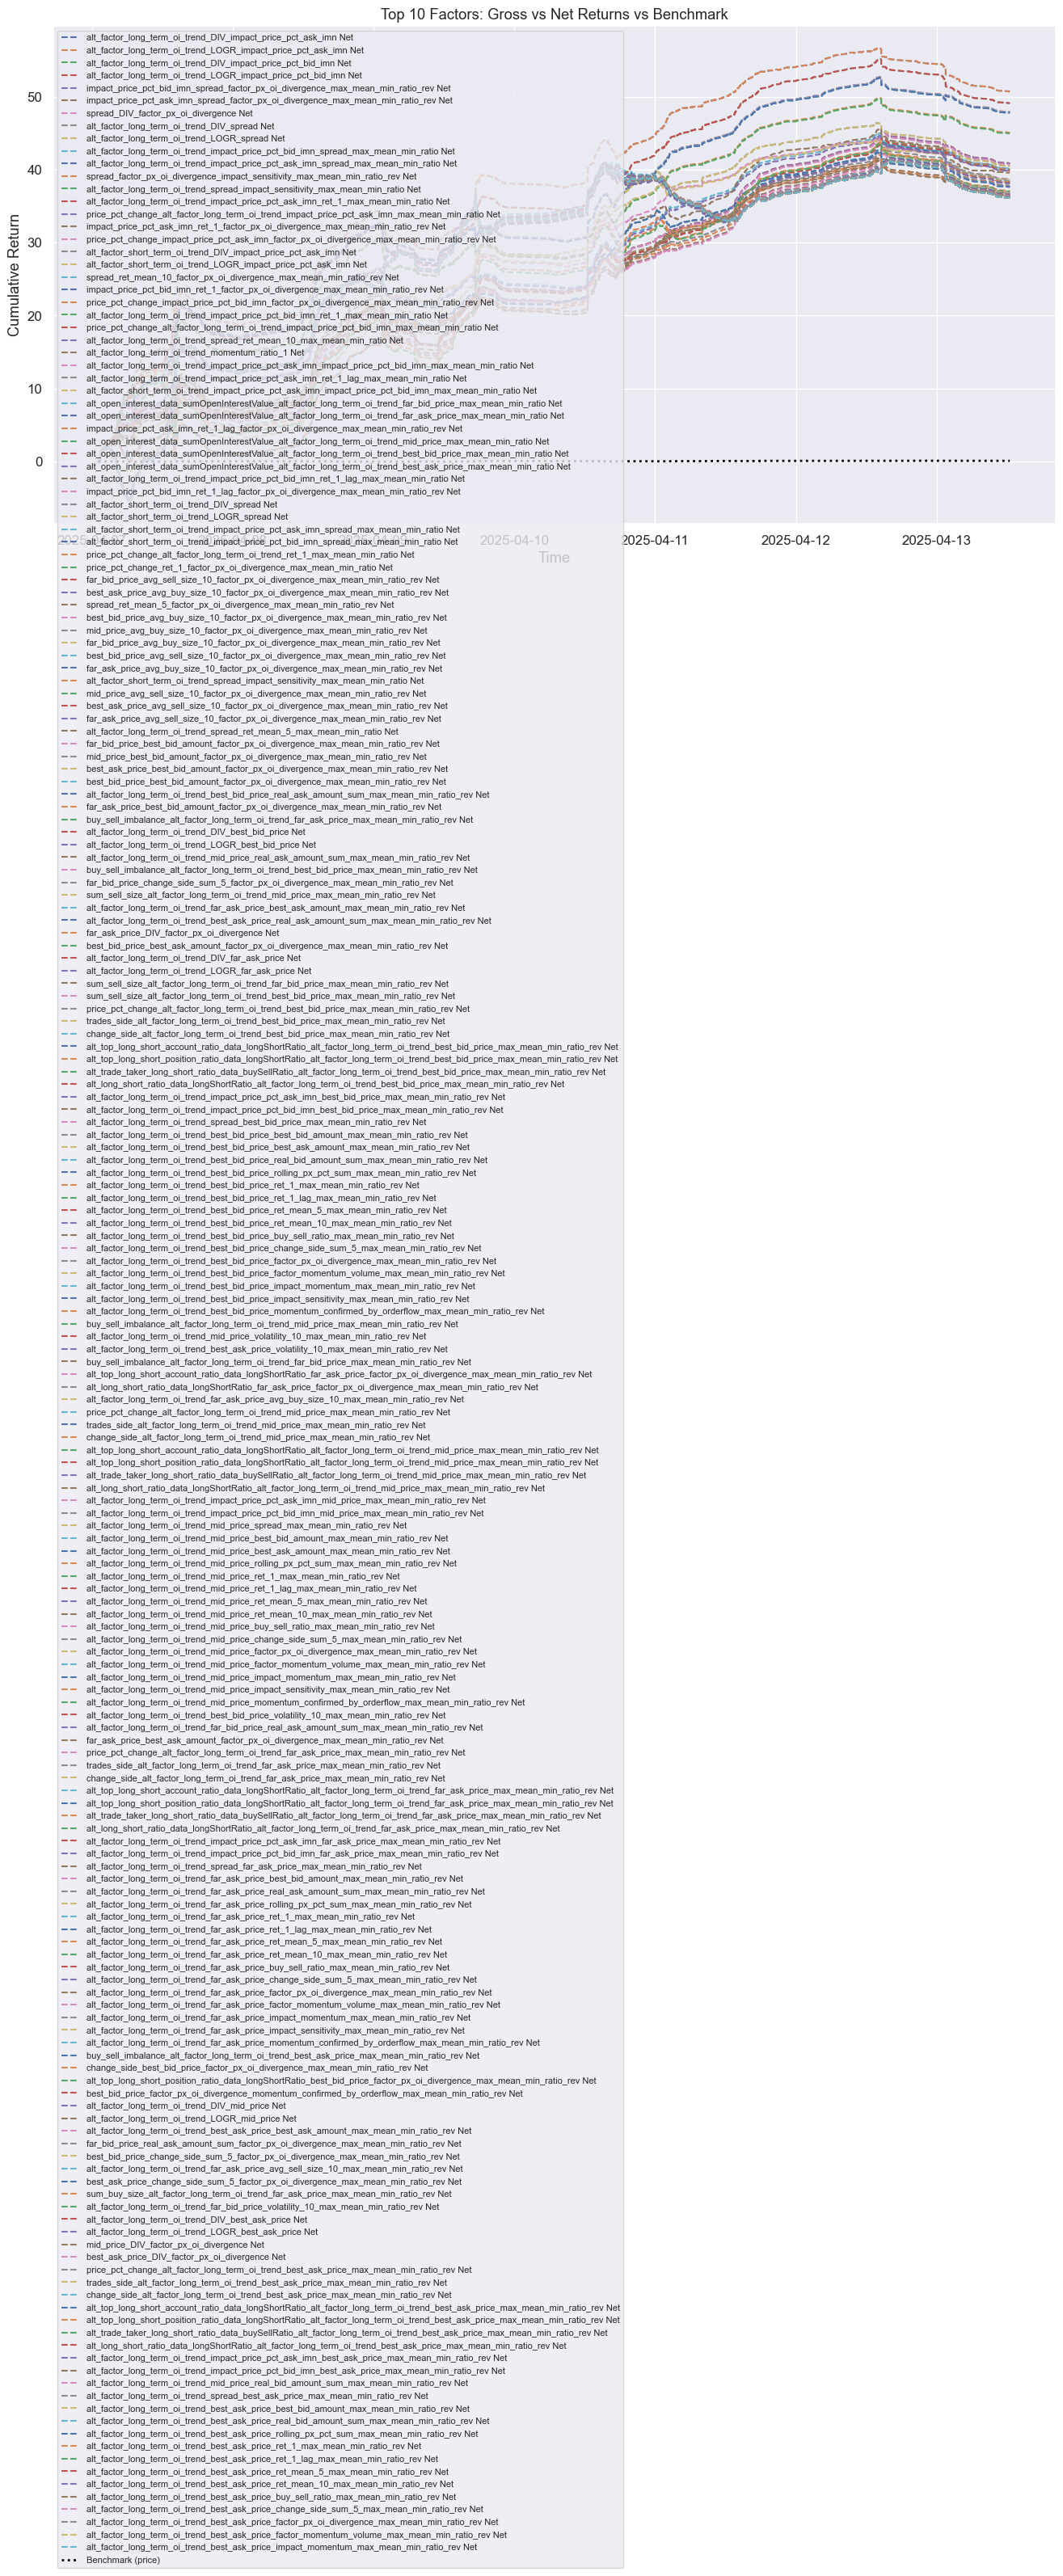

In [63]:
from tqdm import tqdm
import polars as pl
import matplotlib.pyplot as plt

cost_rate = 0.001  # 假设交易成本比例是0.05%
bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col
target_col_for_cal = f"future_return_{avg_steps_2pct}"

# 进一步排除字段名中包含 bug_col 任何一项作为子串的字段
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]


def gen_signal_expr(factor, reverse=False):
    q20 = df.select(pl.col(factor).quantile(0.5)).item()
    q80 = df.select(pl.col(factor).quantile(0.5)).item()
    signal_name = f"signal_{factor}_rev" if reverse else f"signal_{factor}"
    signal = (
        pl.when(pl.col(factor) >= q80).then(1)
          .when(pl.col(factor) <= q20).then(-1)
          .otherwise(0)
          .alias(signal_name)
    )
    if reverse:
        return (signal * -1).alias(signal_name)
    return signal


signal_exprs = []
for f in factors:
    signal_exprs.append(gen_signal_expr(f, reverse=False))
    signal_exprs.append(gen_signal_expr(f, reverse=True))

df_cum_sum = df.with_columns(signal_exprs)
print(df_cum_sum)

for f in tqdm(factors, desc="Calculating strategy returns"):
    signal_col = f"signal_{f}"

    for mode in ["", "_rev"]:  # 空字符串是正向，_rev 是反向
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"
        cum_return_col = f"cum_strategy_return_{f}{mode}"
   
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col) * pl.col(target_col_for_cal)).alias(strategy_return_col)
        ]).with_columns([
            pl.col(strategy_return_col).fill_null(0).cum_sum().alias(cum_return_col)
        ])

for f in tqdm(factors, desc="Calculating costs and net returns"):
      for mode in ["", "_rev"]:
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"

        position_change_col = f"{signal_col}_position_change"
        transaction_cost_col = f"{signal_col}_transaction_cost"
        net_return_col = f"net_return_{f}{mode}"
        cum_net_return_col = f"cum_net_return_{f}{mode}"
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col).diff().abs().fill_null(0)).alias(position_change_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(position_change_col) * cost_rate).alias(transaction_cost_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(strategy_return_col) - pl.col(transaction_cost_col)).alias(net_return_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            pl.col(net_return_col).fill_null(0).cum_sum().alias(cum_net_return_col)
        ])

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["px_short_oi_divergence", "signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]

# 排除不需要的因子
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

# 获取最后一个时间点的净收益值
final_net_returns = df_cum_sum.select(net_return_cols).tail(1).to_dict(as_series=False)

# 根据最后收益排序
sorted_net_returns = sorted(final_net_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:200]
topN_info = []
good_factors = []

for col_name, value in top20:
    is_reversed = col_name.endswith("_rev")
    # 去掉前缀和 _rev 后缀，得到纯净因子名
    clean_name = col_name.replace("cum_net_return_", "")
    if is_reversed:
        clean_name = clean_name.replace("_rev", "")
    topN_info.append({
        "raw_col": col_name,
        "factor": clean_name,
        "is_reversed": is_reversed,
        "final_return": value[0]
    })
    good_factors.append(clean_name)
    
print(top20)
# 提取列名、是否反转的标志
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_net_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))

# 开始画图
plt.figure(figsize=(16, 8))

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # 检查列是否存在
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"⚠️ Missing column for factor {f} (rev={is_rev})")
        continue

    # 获取数据
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # 打印信息
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])

    # 画图
    plt.plot(time, net_arr, label=f"{f}{suffix} Net", linestyle="--")

# benchmark 部分保持不变
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
plt.plot(time, cum_price_return, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Top 10 Factors: Gross vs Net Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [300]:
f = 'spread_skew'
print(df_cum_sum.select([
    f,
    f"signal_{f}",
    f"strategy_return_{f}",
    f"cum_strategy_return_{f}"
]).tail(10))


shape: (10, 4)
┌─────────────┬────────────────────┬─────────────────────────────┬─────────────────────────────────┐
│ spread_skew ┆ signal_spread_skew ┆ strategy_return_spread_skew ┆ cum_strategy_return_spread_ske… │
│ ---         ┆ ---                ┆ ---                         ┆ ---                             │
│ f64         ┆ i32                ┆ f64                         ┆ f64                             │
╞═════════════╪════════════════════╪═════════════════════════════╪═════════════════════════════════╡
│ 8.623803    ┆ 1                  ┆ -0.000507                   ┆ -0.091772                       │
│ 8.623859    ┆ 1                  ┆ -0.000501                   ┆ -0.092273                       │
│ 8.623915    ┆ 1                  ┆ -0.000502                   ┆ -0.092775                       │
│ 8.623971    ┆ 1                  ┆ 0.000502                    ┆ -0.092274                       │
│ 8.625639    ┆ 1                  ┆ -0.000502                   ┆ -0.092776

In [597]:
names = [item[0] for item in top20]
names

['cum_net_return_alt_factor_long_term_oi_trend_momentum_ratio_1',
 'cum_net_return_factor_px_oi_divergence_squared',
 'cum_net_return_factor_px_oi_divergence_rev',
 'cum_net_return_alt_factor_long_term_oi_trend_lag_1',
 'cum_net_return_alt_factor_long_term_oi_trend',
 'cum_net_return_alt_factor_long_term_oi_trend_boxcox_0',
 'cum_net_return_alt_factor_long_term_oi_trend_squared',
 'cum_net_return_alt_factor_long_term_oi_trend_sqrt',
 'cum_net_return_alt_factor_long_term_oi_trend_log1p',
 'cum_net_return_factor_px_oi_divergence_lag_1_rev',
 'cum_net_return_alt_factor_long_term_oi_trend_X_factor_px_oi_divergence_rev',
 'cum_net_return_alt_factor_short_term_oi_trend_momentum_ratio_1',
 'cum_net_return_alt_factor_short_term_oi_trend_lag_1',
 'cum_net_return_alt_factor_short_term_oi_trend',
 'cum_net_return_alt_factor_short_term_oi_trend_boxcox_0',
 'cum_net_return_alt_factor_short_term_oi_trend_squared',
 'cum_net_return_alt_factor_short_term_oi_trend_sqrt',
 'cum_net_return_alt_factor_sho

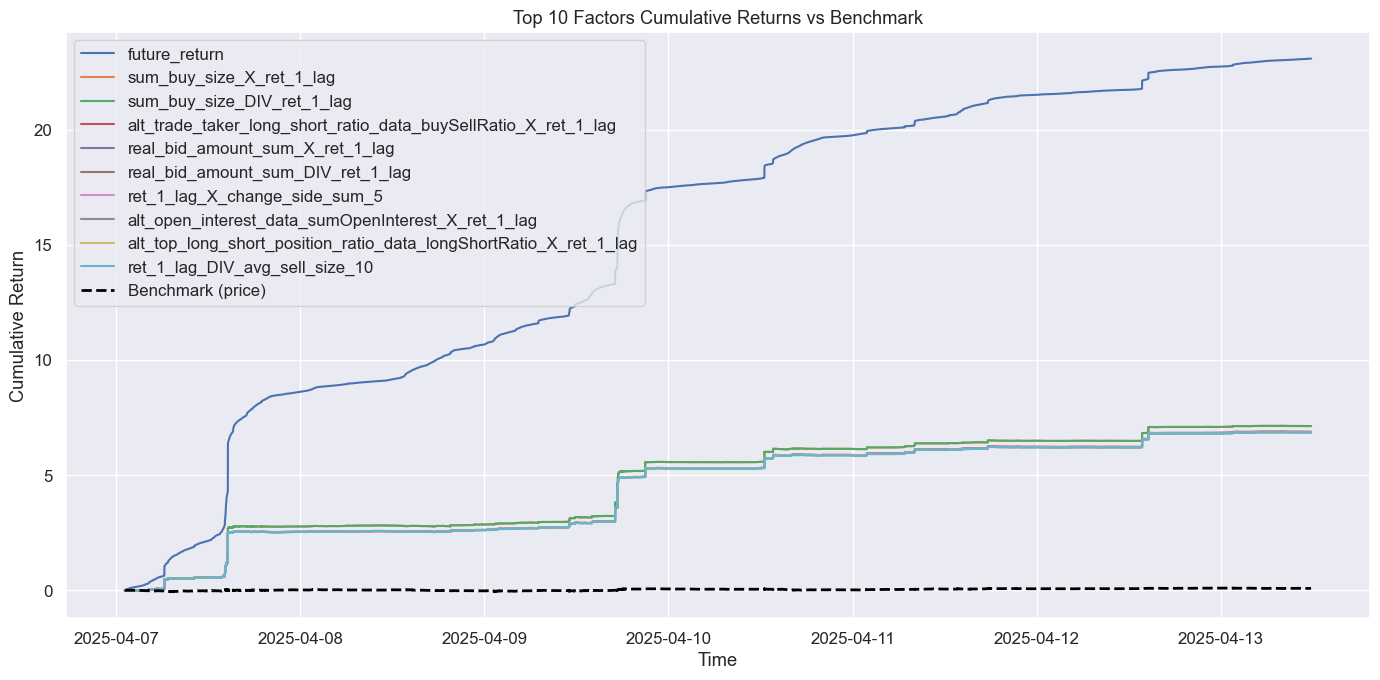

In [301]:
# 提取所有 cum_strategy_return 列
cum_return_cols = [col for col in df_cum_sum.columns if col.startswith("cum_strategy_return_")]

# 提取最后一行每个因子的累计收益
final_cum_returns = df_cum_sum.select(cum_return_cols).tail(1).to_dict(as_series=False)

# 排名，取 Top 10（注意倒序）
sorted_returns = sorted(final_cum_returns.items(), key=lambda x: x[1][0], reverse=True)
top10 = sorted_returns[:10]
top10_cols = [item[0] for item in top10]
# 假设已有价格列叫 price
df_cum_sum = df_cum_sum.with_columns([
    (pl.col("price") / pl.col("price").shift(1) - 1).fill_null(0).alias("price_return")
])

# 累计 price return，作为 benchmark
df_cum_sum = df_cum_sum.with_columns([
    pl.col("price_return").cum_sum().alias("cum_price_return")
])
import matplotlib.pyplot as plt

# 取时间索引（例如 timestamp_dt 或 index）
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

plt.figure(figsize=(14, 7))

# 绘制 Top10 因子
for col in top10_cols:
    plt.plot(time, df_cum_sum[col], label=col.replace("cum_strategy_return_", ""))

# 加入 benchmark（price 累计收益）
plt.plot(time, df_cum_sum["cum_price_return"], label="Benchmark (price)", color="black", linewidth=2, linestyle="--")

plt.title("Top 10 Factors Cumulative Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


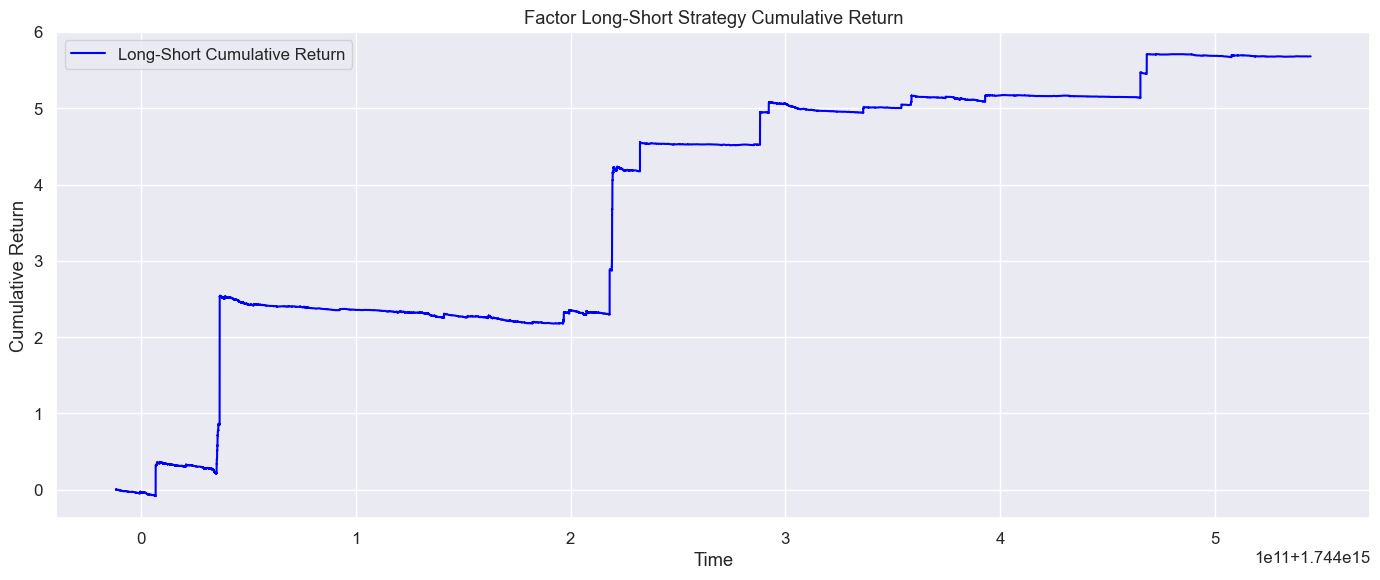

In [302]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 如果你有时间列：比如 'timestamp'
timestamps = df['timestamp'] if 'timestamp' in df.columns else range(len(df))

plt.figure(figsize=(14, 6))
plt.plot(timestamps, df['cum_strategy_return'], label='Long-Short Cumulative Return', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.title('Factor Long-Short Strategy Cumulative Return')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


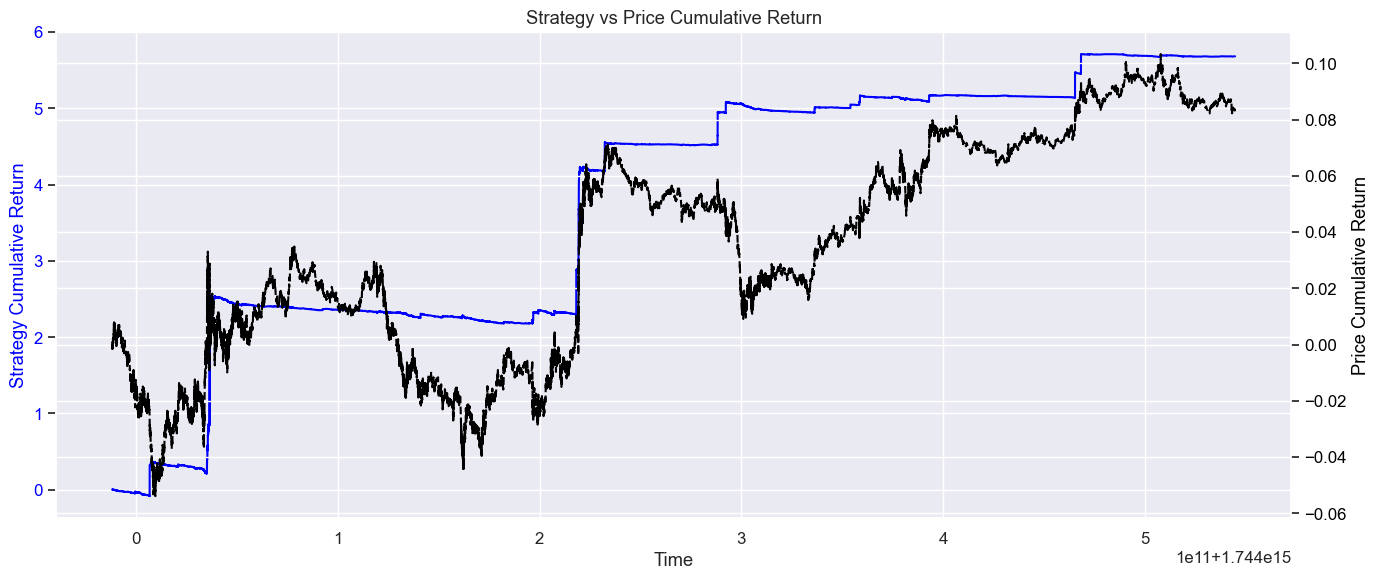

In [291]:
# 单期收益率（变化率）：当期价格 / 上期价格 - 1
df = df.with_columns([
    (pl.col("price") / pl.col("price").shift(1) - 1)
    .fill_null(0)
    .alias("price_return")
])

# 累计收益曲线（benchmark）
df = df.with_columns([
    pl.col("price_return").cum_sum().alias("cum_price_return")
])
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt

timestamps = df['timestamp'] if 'timestamp' in df.columns else range(len(df))

fig, ax1 = plt.subplots(figsize=(14, 6))

# 左边 Y 轴：策略收益
ax1.plot(timestamps, df['cum_strategy_return'], label='Strategy Cumulative Return', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Strategy Cumulative Return', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# 右边 Y 轴：价格收益
ax2 = ax1.twinx()
ax2.plot(timestamps, df['cum_price_return'], label='Price Cumulative Return', color='black', linestyle='--')
ax2.set_ylabel('Price Cumulative Return', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 标题和图例
plt.title('Strategy vs Price Cumulative Return')
fig.tight_layout()
plt.show()

plt.show()


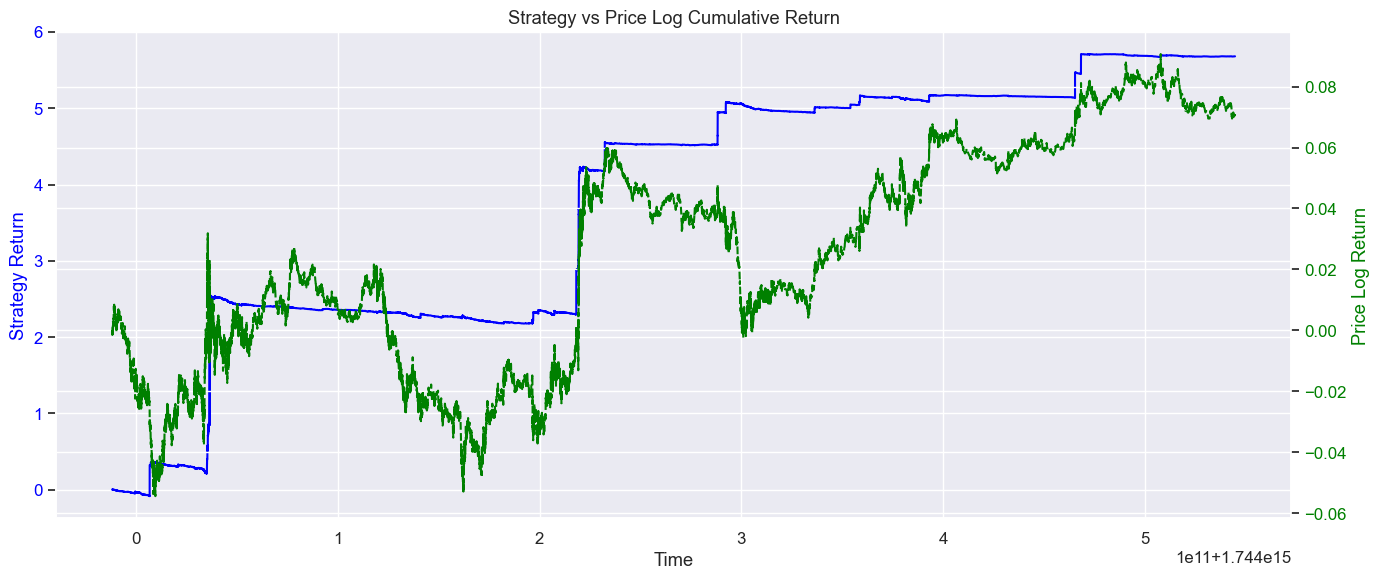

In [297]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 获取横轴
timestamps = df['timestamp'].to_numpy() if 'timestamp' in df.columns else range(len(df))

# 转成 NumPy 用于绘图
cum_strat = df['cum_strategy_return'].to_numpy()
cum_price_log = df['cum_log_price_return'].to_numpy()

# 创建图像
fig, ax1 = plt.subplots(figsize=(14, 6))

# 画策略收益
ax1.plot(timestamps, cum_strat, label='Strategy Cumulative Return', color='blue')
ax1.set_xlabel("Time")
ax1.set_ylabel("Strategy Return", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 第二个 y 轴（右侧）
ax2 = ax1.twinx()
ax2.plot(timestamps, cum_price_log, label='Price Cumulative Log Return', color='green', linestyle='--')
ax2.set_ylabel("Price Log Return", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 标题 & 格式
plt.title("Strategy vs Price Log Cumulative Return")
ax1.grid(True)
fig.tight_layout()
plt.show()


Max Drawdown: 0.059889
Smoothness (mean abs second diff): 0.000802
Volatility (std of returns): 0.000826


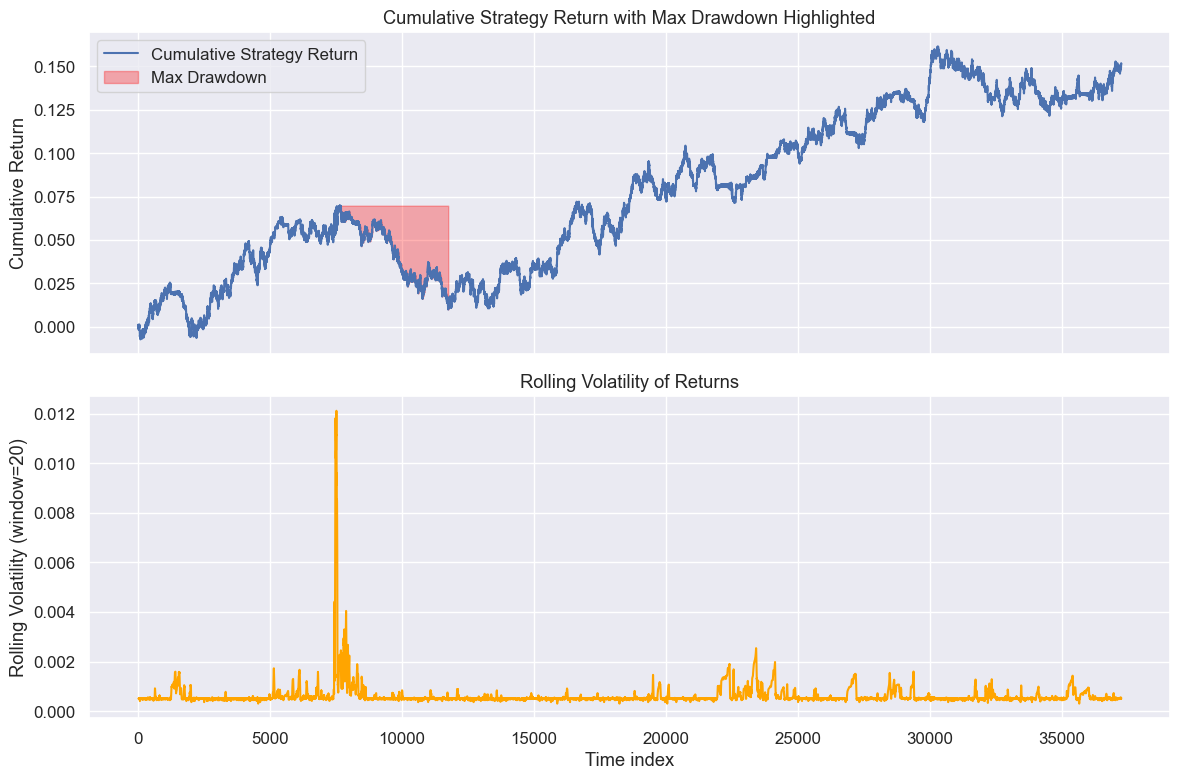

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的 DataFrame 里有 cum_strategy_return 列
cum_returns = df['cum_strategy_return'].to_numpy()

# 计算最大回撤
running_max = np.maximum.accumulate(cum_returns)
drawdowns = running_max - cum_returns
max_drawdown = np.max(drawdowns)
max_dd_idx = np.argmax(drawdowns)
start_idx = np.argmax(cum_returns[:max_dd_idx])
end_idx = max_dd_idx

# 计算滑动窗口波动率，窗口长度自行调整（例如20）
window = 20
rolling_vol = pd.Series(cum_returns).diff().rolling(window=window).std()

# 计算顺滑度（平均二阶差分绝对值）
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))

# 计算波动率（收益的一阶差分标准差）
volatility = np.std(np.diff(cum_returns))

print(f"Max Drawdown: {max_drawdown:.6f}")
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")
print(f"Volatility (std of returns): {volatility:.6f}")

# 画图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# 累积收益曲线
ax1.plot(cum_returns, label='Cumulative Strategy Return')
# 标注最大回撤区间
ax1.fill_between(range(start_idx, end_idx+1), cum_returns[start_idx:end_idx+1], running_max[start_idx:end_idx+1], 
                 color='red', alpha=0.3, label='Max Drawdown')
ax1.set_ylabel('Cumulative Return')
ax1.set_title('Cumulative Strategy Return with Max Drawdown Highlighted')
ax1.legend()
ax1.grid(True)

# 滑动窗口波动率
ax2.plot(rolling_vol, color='orange')
ax2.set_ylabel('Rolling Volatility (window=20)')
ax2.set_xlabel('Time index')
ax2.set_title('Rolling Volatility of Returns')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [146]:
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")


Smoothness (mean abs second diff): 0.000270


In [147]:
import pandas as pd

returns = pd.Series(np.diff(cum_returns))
autocorr = returns.autocorr(lag=100)
print(f"Autocorrelation of returns (lag=1): {autocorr:.4f}")


Autocorrelation of returns (lag=1): -0.0131


In [148]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    sharpe = mean_excess_return / std_excess_return
    return sharpe


sharpe = sharpe_ratio_non_annualized(cum_returns)

print(f"Non-annualized Sharpe Ratio: {sharpe:.4f}")


Non-annualized Sharpe Ratio: 1.4500


In [428]:
df

shape: (37_235, 3_123)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬──────────────┬──────────────────┬──────────────────┬──────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ price_return ┆ cum_price_return ┆ log_price_return ┆ cum_log_price_return │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---          ┆ ---              ┆ ---              ┆ ---                  │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ f64          ┆ f64              ┆ f64              ┆ f64                  │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪══════════════╪══════════════════╪══════════════════╪══════════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 0.0          ┆ 0.0              ┆ 0.0              ┆ 0.0                  │
│ 1743988109683000 ┆ 78596.7 ┆ 12.658       ┆ 11.859        ┆ … ┆ -0.000504    ┆ -0.000504        ┆ -0.000504        ┆ -0.000504            │
│ 1743988117612000 ┆ 78557.2 ┆ 9.64         ┆ 19.887        ┆ … ┆ -0.000503    ┆ -0.001006        ┆ -0.000503        ┆ -0.001006            │
│ 1743988127362000 ┆ 78517.7 ┆ 7.196        ┆ 18.613        ┆ … ┆ -0.000503    ┆ -0.001509        ┆ -0.000503        ┆ -0.001509            │
│ 1743988142162000 ┆ 78557.5 ┆ 27.117       ┆ 11.867        ┆ … ┆ 0.000507     ┆ -0.001002        ┆ 0.000507         ┆ -0.001003            │
│ …                ┆ …       ┆ …            ┆ …             ┆ … ┆ …            ┆ …                ┆ …                ┆ …                    │
│ 1744543829538000 ┆ 84465.1 ┆ 17.848       ┆ 24.44         ┆ … ┆ 0.000501     ┆ 0.084221         ┆ 0.000501         ┆ 0.071505             │
│ 1744543882436000 ┆ 84422.3 ┆ 31.55        ┆ 32.298        ┆ … ┆ -0.000507    ┆ 0.083714         ┆ -0.000507        ┆ 0.070998             │
│ 1744543904805000 ┆ 84380.0 ┆ 9.245        ┆ 27.131        ┆ … ┆ -0.000501    ┆ 0.083213         ┆ -0.000501        ┆ 0.070497             │
│ 1744543932419000 ┆ 84337.6 ┆ 14.459       ┆ 72.835        ┆ … ┆ -0.000502    ┆ 0.082711         ┆ -0.000503        ┆ 0.069994             │
│ 1744543966713000 ┆ 84379.9 ┆ 24.817       ┆ 27.363        ┆ … ┆ 0.000502     ┆ 0.083212         ┆ 0.000501         ┆ 0.070496             │
└──────────────────┴─────────┴──────────────┴───────────────┴───┴──────────────┴──────────────────┴──────────────────┴──────────────────────┘

In [72]:
ic_rank = good_factors      # 假设：根据 IC 值排名靠前的因子
sharpe_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_best_bid_price',]   # 假设：基于因子组合夏普率排序
cumret_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_best_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_bid_price']   # 假设：基于因子组合累计收益排序
ir_rank =[]     # 假设：根据 IC 值排名靠前的因子

bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col

# 进一步排除字段名中包含 bug_col 任何一项作为子串的字段
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]
target_col_for_cal = f"future_return_{avg_steps_2pct}"


In [74]:
# 创建统一的“保留因子”集合（任意一个榜单入选就保留）
keep_set = set(ic_rank) | set(ir_rank) | set(sharpe_rank) | set(cumret_rank)
# 用 list 推导生成新因子池
filtered_factors = [f for f in factors if f in keep_set]

# 可选：打印保留了多少
print(f"保留因子数：{len(filtered_factors)} / 原始因子数：{len(factors)}")

# 可选：提取出新的 Polars 子 DataFrame
filtered_df = df.select(filtered_factors + [target_col_for_cal])  # 加上目标列方便后续建模


保留因子数：207 / 原始因子数：31608


In [76]:
rank_weights = {
    "ic": 1.2,
    "ir": 1.0,
    "sharpe": 1.2,
    "cumret": 1.5,
}

# 每个因子打分
from collections import defaultdict

score = defaultdict(float)
for f in ic_rank:
    score[f] += rank_weights["ic"]
for f in ir_rank:
    score[f] += rank_weights["ir"]
for f in sharpe_rank:
    score[f] += rank_weights["sharpe"]
for f in cumret_rank:
    score[f] += rank_weights["cumret"]

# 只保留分数大于一定阈值的因子
filtered_factors = [f for f in factors if score[f] >= 1.0]
print(filtered_factors)

['alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_mid_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_bid_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_ask_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_far_ask_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_best_bid_price', 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_best_ask_price', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_LOGR_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_short_term_oi_trend_LOGR_spread', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_long_term_oi_trend_LOGR_impact_price_pct_ask_imn', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_long_term_oi_trend_LOGR_impact_

In [78]:
def pl_dropna(df: pl.DataFrame) -> pl.DataFrame:

    pdf = df.to_pandas()
    pdf_clean = pdf.dropna()
    return pl.from_pandas(pdf_clean)

In [80]:
def filter_by_spearman_corr(df: pl.DataFrame, factor_cols: list[str], threshold: float = 0.9) -> list[str]:
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    
    corr_matrix, _ = spearmanr(matrix)  # 一次性计算所有因子的 Spearman 相关系数矩阵，shape = (n, n)
    n = len(factor_cols)
    keep = []
    removed = set()
    
    print("Spearman correlation matrix:")
    print(np.round(corr_matrix, 3))
    
    for i in range(n):
        if factor_cols[i] in removed:
            # print(f"Skip {factor_cols[i]} as it is removed")
            continue
        keep.append(factor_cols[i])
        # print(f"Keep {factor_cols[i]}")
        
        for j in range(i+1, n):
            if factor_cols[j] in removed:
                continue

            corr_value = corr_matrix[i, j]

            if abs(corr_value) >= threshold:
                removed.add(factor_cols[j])
                # print(f"Remove {factor_cols[j]} because corr({factor_cols[i]}, {factor_cols[j]}) = {corr_value:.3f} >= {threshold}")

    return keep


In [82]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    """
    根据互信息保留前 top_k 个和目标变量相关性最强的因子。

    Args:
        df: Polars DataFrame
        factor_cols: 原始因子列
        target_col: 目标收益列
        top_k: 保留前 k 个因子

    Returns:
        保留的因子列名列表
    """
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected


In [84]:
f_df = df.select(filtered_factors + [target_col_for_cal]).drop_nulls()
f_df

shape: (7_407, 208)
┌─────────────────┬─────────────────┬─────────────────┬─────────────────┬───┬─────────────────┬─────────────────┬────────────────┬────────────────┐
│ alt_factor_long ┆ alt_trade_taker ┆ alt_trade_taker ┆ alt_trade_taker ┆ … ┆ best_ask_price_ ┆ best_ask_price_ ┆ best_ask_price ┆ future_return_ │
│ _term_oi_trend_ ┆ _long_short_rat ┆ _long_short_rat ┆ _long_short_rat ┆   ┆ avg_buy_size_10 ┆ avg_sell_size_1 ┆ _change_side_s ┆ 1312           │
│ …               ┆ …               ┆ …               ┆ …               ┆   ┆ …               ┆ …               ┆ um…            ┆ ---            │
│ ---             ┆ ---             ┆ ---             ┆ ---             ┆   ┆ ---             ┆ ---             ┆ ---            ┆ f64            │
│ f64             ┆ f64             ┆ f64             ┆ f64             ┆   ┆ f64             ┆ f64             ┆ f64            ┆                │
╞═════════════════╪═════════════════╪═════════════════╪═════════════════╪═══╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ 1.0             ┆ 0.000009        ┆ -11.590992      ┆ 0.000009        ┆ … ┆ 1.024992        ┆ 1.024997        ┆ 1.025181       ┆ -0.027302      │
│ 1.0             ┆ 0.000009        ┆ -11.590526      ┆ 0.000009        ┆ … ┆ 1.024835        ┆ 1.02484         ┆ 1.025028       ┆ -0.027846      │
│ 1.0             ┆ 0.000009        ┆ -11.589528      ┆ 0.000009        ┆ … ┆ 1.024485        ┆ 1.024419        ┆ 1.024705       ┆ -0.026867      │
│ 1.0             ┆ 0.000009        ┆ -11.589092      ┆ 0.000009        ┆ … ┆ 1.024422        ┆ 1.024364        ┆ 1.024556       ┆ -0.025342      │
│ 1.0             ┆ 0.000016        ┆ -11.056489      ┆ 0.000016        ┆ … ┆ 1.025006        ┆ 1.024953        ┆ 1.025198       ┆ -0.027295      │
│ …               ┆ …               ┆ …               ┆ …               ┆ … ┆ …               ┆ …               ┆ …              ┆ …              │
│ 0.999989        ┆ 0.00001         ┆ -11.554094      ┆ 0.00001         ┆ … ┆ 1.016003        ┆ 1.016113        ┆ 1.01681        ┆ -0.014267      │
│ 1.0             ┆ 0.000006        ┆ -12.080941      ┆ 0.000006        ┆ … ┆ 1.015619        ┆ 1.015458        ┆ 1.015989       ┆ -0.0083        │
│ 1.0             ┆ 0.000006        ┆ -12.080449      ┆ 0.000006        ┆ … ┆ 1.015493        ┆ 1.015206        ┆ 1.015822       ┆ -0.008298      │
│ 1.0             ┆ 0.000014        ┆ -11.155061      ┆ 0.000014        ┆ … ┆ 1.015466        ┆ 1.015244        ┆ 1.015863       ┆ -0.007304      │
│ 1.0             ┆ 0.000014        ┆ -11.154437      ┆ 0.000014        ┆ … ┆ 1.01522         ┆ 1.014951        ┆ 1.015652       ┆ -0.007307      │
└─────────────────┴─────────────────┴─────────────────┴─────────────────┴───┴─────────────────┴─────────────────┴────────────────┴────────────────┘

In [115]:
# 第一步：先用 spearman 过滤冗余
low_corr_factors = filter_by_spearman_corr(df, factor_cols=df.columns, threshold=0.8)

# 第二步：再用 MI 选出前 k 个信息量最大的因子
final_selected_factors = filter_by_mutual_info(f_df, low_corr_factors, target_col=target_col_for_cal, top_k=30)


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [109]:
print(low_corr_factors)
print(final_selected_factors)
# ['alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio']
# ['alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio']

['alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio']
['alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_momentum_ratio_1']


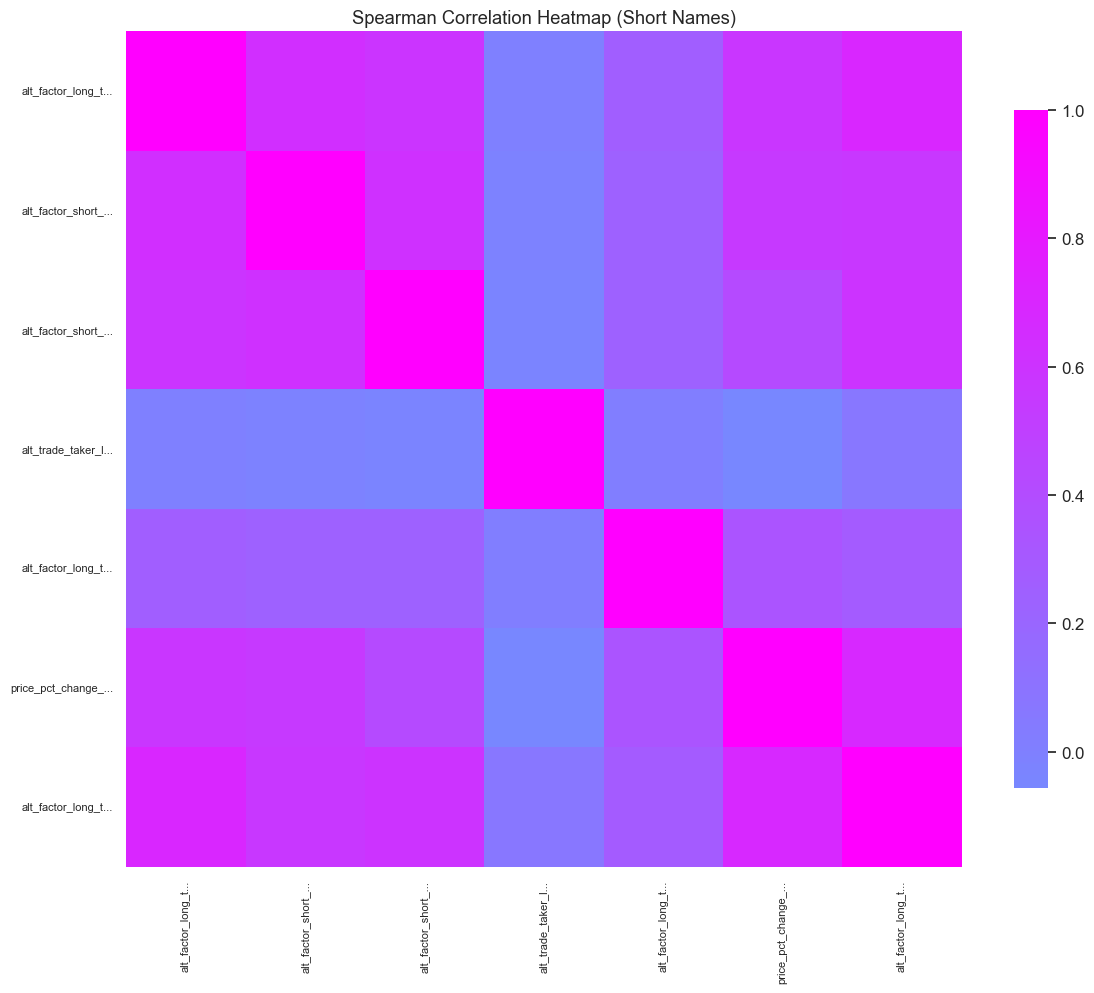

corr_matrix max: 1.0
corr_matrix min: -0.05679738823480321
corr_matrix mean: 0.4397208055114004


In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

def plot_spearman_corr_heatmap(df: pl.DataFrame, factor_cols: list[str], max_len: int = 20):
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    corr_matrix, _ = spearmanr(matrix)

    # 截断长名称
    short_names = [name if len(name) <= max_len else name[:max_len-3] + "..." for name in factor_cols]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix,
                xticklabels=short_names,
                yticklabels=short_names,
                cmap='cool',
                center=0,
                annot=False,
                square=True,
                cbar_kws={"shrink": .8})

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.title("Spearman Correlation Heatmap (Short Names)")
    plt.tight_layout()
    plt.show()
    print("corr_matrix max:", np.max(corr_matrix))
    print("corr_matrix min:", np.min(corr_matrix))
    print("corr_matrix mean:", np.mean(corr_matrix))

plot_spearman_corr_heatmap(f_df, final_selected_factors)

In [468]:
df = df.drop_nulls()
df

shape: (37_234, 3_123)
┌──────────────────┬─────────┬──────────────┬───────────────┬───┬──────────────┬──────────────────┬──────────────────┬──────────────────────┐
│ timestamp        ┆ price   ┆ sum_buy_size ┆ sum_sell_size ┆ … ┆ price_return ┆ cum_price_return ┆ log_price_return ┆ cum_log_price_return │
│ ---              ┆ ---     ┆ ---          ┆ ---           ┆   ┆ ---          ┆ ---              ┆ ---              ┆ ---                  │
│ i64              ┆ f64     ┆ f64          ┆ f64           ┆   ┆ f64          ┆ f64              ┆ f64              ┆ f64                  │
╞══════════════════╪═════════╪══════════════╪═══════════════╪═══╪══════════════╪══════════════════╪══════════════════╪══════════════════════╡
│ 1743988103953000 ┆ 78636.3 ┆ 16.591       ┆ 9.189         ┆ … ┆ 0.0          ┆ 0.0              ┆ 0.0              ┆ 0.0                  │
│ 1743988109683000 ┆ 78596.7 ┆ 12.658       ┆ 11.859        ┆ … ┆ -0.000504    ┆ -0.000504        ┆ -0.000504        ┆ -0.000504            │
│ 1743988117612000 ┆ 78557.2 ┆ 9.64         ┆ 19.887        ┆ … ┆ -0.000503    ┆ -0.001006        ┆ -0.000503        ┆ -0.001006            │
│ 1743988127362000 ┆ 78517.7 ┆ 7.196        ┆ 18.613        ┆ … ┆ -0.000503    ┆ -0.001509        ┆ -0.000503        ┆ -0.001509            │
│ 1743988142162000 ┆ 78557.5 ┆ 27.117       ┆ 11.867        ┆ … ┆ 0.000507     ┆ -0.001002        ┆ 0.000507         ┆ -0.001003            │
│ …                ┆ …       ┆ …            ┆ …             ┆ … ┆ …            ┆ …                ┆ …                ┆ …                    │
│ 1744543802841000 ┆ 84422.8 ┆ 100.13       ┆ 90.865        ┆ … ┆ -0.000501    ┆ 0.08372          ┆ -0.000501        ┆ 0.071004             │
│ 1744543829538000 ┆ 84465.1 ┆ 17.848       ┆ 24.44         ┆ … ┆ 0.000501     ┆ 0.084221         ┆ 0.000501         ┆ 0.071505             │
│ 1744543882436000 ┆ 84422.3 ┆ 31.55        ┆ 32.298        ┆ … ┆ -0.000507    ┆ 0.083714         ┆ -0.000507        ┆ 0.070998             │
│ 1744543904805000 ┆ 84380.0 ┆ 9.245        ┆ 27.131        ┆ … ┆ -0.000501    ┆ 0.083213         ┆ -0.000501        ┆ 0.070497             │
│ 1744543932419000 ┆ 84337.6 ┆ 14.459       ┆ 72.835        ┆ … ┆ -0.000502    ┆ 0.082711         ┆ -0.000503        ┆ 0.069994             │
└──────────────────┴─────────┴──────────────┴───────────────┴───┴──────────────┴──────────────────┴──────────────────┴──────────────────────┘